In [1]:

import numpy as np
import pandas as pd
from sktime.transformations.panel.shapelet_transform import ShapeletTransform
from sktime.transformations.series.fourier import FourierTransform
from sktime.transformations.panel.catch22 import Catch22
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore')


In [2]:
X_train_orig = pd.read_csv('X_train.csv')
y_train_orig = pd.read_csv('y_train.csv')
X_test_orig = pd.read_csv('X_test.csv')

In [3]:
def equalDistrLabel(X,y):
    vals = y['y'].value_counts()
    print(vals)

equalDistrLabel(X_train_orig,y_train_orig)

y
0    3030
2    1474
1     443
3     170
Name: count, dtype: int64


In [ ]:
# Returns a Test dataset that contains an equal amounts of each class
# y should contain only two classes 0 and 1
def TrainSplitEqualBinary(X, y, samples_n): #samples_n per class
    
    indicesClass1 = []
    indicesClass2 = []
    indicesClass3 = []
    indicesClass4 = []
    
    for i in range(0, len(y)):
        if y[i] == 0 and len(indicesClass1) < samples_n:
            indicesClass1.append(i)
        elif y[i] == 1 and len(indicesClass2) < samples_n:
            indicesClass2.append(i)
        elif y[i] == 2 and len(indicesClass3) < samples_n:
            indicesClass3.append(i)
        elif y[i] == 3 and len(indicesClass4) < samples_n:
            indicesClass4.append(i)
            
        if len(indicesClass1) == samples_n and len(indicesClass2) == samples_n and len(indicesClass3) == samples_n and len(indicesClass4) == samples_n:
            break
    
    X_test_class1 = X[indicesClass1]
    X_test_class2 = X[indicesClass2]
    X_test_class3 = X[indicesClass3]
    X_test_class4 = X[indicesClass4]
    
    X_test = np.concatenate((X_test_class1,X_test_class2), axis=0)
    
    #remove x_test from X
    X_train = np.delete(X, indicesClass1 + indicesClass2, axis=0)
    
    Y_test_class1 = y[indicesClass1]
    Y_test_class2 = y[indicesClass2]
    
    y_test = np.concatenate((Y_test_class1,Y_test_class2), axis=0)
    
    #remove y_test from y
    y_train = np.delete(y, indicesClass1 + indicesClass2, axis=0)
    
    if (X_test.shape[0] != 2 * samples_n or y_test.shape[0] != 2 * samples_n):
        raise Exception("Problem with split 1!")
        
    if (X_train.shape[0] + X_test.shape[0] != X.shape[0] or y_train.shape[0] + y_test.shape[0] != y.shape[0]):
        raise Exception("Problem with split 2!")
    
    return X_train, X_test, y_train, y_test

In [4]:
label=y_train_orig.iloc[:,1]
feature=X_train_orig.iloc[:,1:2459].dropna(axis=1).to_numpy()
X_test_features = X_test_orig.iloc[:,1:2459].dropna(axis=1).to_numpy()
print(label.shape)
print(feature.shape,X_train_orig.shape)
print(X_test_features.shape,X_test_orig.shape)
print((X_train_orig.dropna(axis=1)))

(5117,)
(5117, 2458) (5117, 17808)
(3411, 2458) (3411, 17808)
        id   x0   x1   x2   x3   x4   x5   x6   x7   x8  ...  x2449  x2450  \
0        0  -13   -9   -6   -4    0    2    6   12   23  ...    -37    -41   
1        1  -34  110  249  390  527  639  721  777  823  ...    -64    -47   
2        2  -34  -36  -37  -39  -41  -42  -44  -46  -48  ...     16     25   
3        3  292  298  303  310  320  336  354  377  405  ...    293     93   
4        4  157  179  195  210  217  222  226  228  231  ...      6     10   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
5112  5112 -247 -271 -285 -303 -334 -376 -413 -432 -443  ...    131    148   
5113  5113   62   62   61   61   61   61   61   61   61  ...    -71    -72   
5114  5114  -95 -110 -124 -131 -126 -114  -95  -67  -42  ...   -106   -103   
5115  5115  -50  -48  -45  -42  -38  -35  -32  -30  -28  ...    -24    -21   
5116  5116   66   65   63   62   65   72   80   84   87  ...    -52    -62   

 

In [11]:
# doesn't work
X_train_shapelet = ShapeletTransform().fit_transform(feature,label)

ValueError: no series scitypes supported, bug in estimator

In [5]:
#X_train_fourier = FourierTransform().fit_transform(feature.T).T
X_train_fourier = pd.read_csv('fourier.csv')
#X_train_fourier = pd.DataFrame(X_train_fourier)
X_train_fourier

,0,1,2,3,4,5,6,7,8,9,...,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228
0,11301.739846,6240.507665,11986.275387,2643.156518,24564.281596,19876.139944,12746.579700,17761.576025,15707.006404,29343.352938,...,40.865032,12.164279,26.826921,37.250091,52.121101,16.331814,23.238957,24.889935,29.260069,68.0
1,92522.260351,77149.415037,124118.801701,116093.883741,152316.270128,87372.139474,15568.920607,96371.274932,75185.989687,13136.878826,...,101.635245,104.235550,65.089470,150.412994,162.925595,78.165454,116.626217,133.766628,134.271618,131.0
2,20078.524499,71883.664327,122546.766195,163046.267932,149997.596162,169282.405091,159759.268187,158554.290586,178573.790629,95172.372177,...,57.813006,62.542231,55.201142,109.186361,21.045566,86.996080,76.853152,77.460212,52.755970,42.0
3,30590.394153,38473.928735,32220.087777,40374.562501,67543.277750,54527.786688,64248.839512,63647.453418,46262.369713,54262.488079,...,361.132625,383.942799,390.978120,313.298401,401.655242,364.607381,417.155552,319.979694,364.538693,400.0
4,17741.586562,61560.231189,58948.446174,64768.775549,20233.398761,69272.751320,63712.575771,88121.305486,40871.862582,14939.384750,...,135.857181,233.015814,103.587180,221.041073,82.959748,144.809769,63.785812,61.493559,31.222218,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,168833.932869,151095.426558,68368.636962,72996.304578,24605.323967,14299.269370,182085.736313,266710.138631,214273.348121,189373.758983,...,325.032678,213.361943,215.194624,314.494125,285.378239,297.327064,309.611820,306.983004,330.130760,162.0
5113,3362.711400,2989.202763,3733.347565,14851.694557,12085.704770,10862.260348,16069.987442,10656.552190,41629.478941,44034.480984,...,33.917669,43.626754,51.699731,104.263045,70.346880,76.460322,99.261058,89.640930,57.595322,75.0
5114,27816.583074,74295.575856,143255.109176,128436.738173,57951.323577,22283.304987,34758.968308,56256.595666,76972.599828,82001.918843,...,51.791031,15.800292,45.582123,58.595601,117.673625,67.785541,34.707552,46.392041,59.062992,120.0
5115,12683.367524,27052.739118,23359.507225,9713.706106,48317.173658,15369.508037,29983.052408,19258.741676,61294.121446,24725.158558,...,42.401417,17.732891,18.706535,51.475538,40.478675,27.993385,33.514960,23.460013,31.116581,34.0


In [6]:
X_heartpy_features = pd.read_csv('heartpy_features.csv')
X_heartpy_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,231.101647,259.626016,144.519842,110.473528,234.673725,0.970443,0.940887,133.333333,165.938992,118.114752,61574.722092,1.404896,0.200000,738.0,-236.0,-22.0,9.164318,108.995377,11879.992115
1,287.795346,208.481481,141.586392,116.269604,216.733060,0.987179,0.923077,70.000000,153.006111,131.124204,63029.159309,1.166879,0.320256,869.0,-399.0,-4.0,10.273939,138.783053,19260.735784
2,66.622604,900.595238,35.779900,14.470719,27.456259,0.538462,0.038462,21.666667,19.247856,47.173564,2852.534576,0.408022,0.238020,1588.0,-976.0,1.0,15.542128,199.155837,39663.047496
3,312.428734,192.043796,119.795208,135.480749,206.670679,0.888060,0.671642,46.666667,146.113779,82.517256,37877.893952,1.770706,0.152288,864.0,-874.0,-37.0,-21.419640,212.484887,45149.827344
4,253.798768,236.407767,131.244717,106.603936,203.897400,0.969388,0.897959,73.333333,143.859112,110.936061,50137.189915,1.296775,0.164480,679.0,-737.0,-19.0,-18.014299,159.854011,25553.304806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,375.733855,159.687500,119.202673,116.808236,184.267688,0.859649,0.719298,76.666667,129.940218,112.638790,45981.320488,1.153601,0.196098,1368.0,-1922.0,-14.0,-16.092070,350.537097,122876.256127
5113,69.394354,864.623656,14.083148,7.272475,10.327956,0.033333,0.000000,6.666667,7.241854,17.216845,391.699654,0.420626,0.186616,515.0,-157.0,7.0,7.195715,77.807021,6053.932526
5114,213.276231,281.325301,170.847905,140.921524,274.358221,0.974684,0.911392,120.000000,193.969150,137.299422,83666.431327,1.412746,0.257279,976.0,-801.0,-30.0,-1.394501,193.885203,37591.472054
5115,71.419429,840.107527,56.653913,57.602609,67.975655,0.448276,0.206897,23.333333,47.578710,43.812558,6548.791224,1.085961,0.268920,397.0,-243.0,-6.0,7.786691,70.217532,4930.501861


In [7]:
X_tsfel_features = pd.read_csv('tsfel_features.csv').iloc[:,1:]
X_tsfel_features

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,25794514.0,537.923333,25794514.0,3.149513e+06,3.631204,491.0,1966.0,-49.0,55.0,0.000407,...,299.804718,4223.587242,12783.209999,23293.870700,34811.243747,47250.480768,60509.881833,74208.404788,87778.497770,105.0
1,107429063.0,1118.168333,107429063.0,1.311710e+07,2.396079,491.0,1966.0,-103.0,123.0,0.000407,...,162.580094,2415.816905,8367.300786,16296.346594,24217.329817,31835.858132,39843.884688,49008.809034,59861.760865,75.0
2,209472268.0,1333.945000,209472268.0,2.557659e+07,3.247673,491.0,1966.0,-82.0,123.0,0.000407,...,1309.063414,19448.019628,56758.271546,91146.552166,113794.291520,127087.681910,134956.937398,139933.573831,143133.132074,49.0
3,126242816.0,1372.405000,126242816.0,1.541426e+07,3.904079,491.0,1966.0,-166.0,144.0,0.000407,...,1677.964784,29432.362652,102202.255590,184589.643590,245478.774478,281863.928205,302040.039507,314206.637423,323916.586838,84.0
4,71536648.0,1060.050000,71536648.0,8.734633e+06,3.395714,491.0,1966.0,-150.0,124.0,0.000407,...,729.931705,10720.861576,30892.681554,47777.218039,56642.641427,60679.492368,63691.659360,67834.198591,74164.696658,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,465299992.0,2503.436667,465299992.0,5.681319e+07,2.259464,491.0,1966.0,-307.0,233.0,0.000407,...,1995.421261,32854.993837,112355.891891,201993.371737,263172.939831,298458.094471,331258.761721,377053.823975,437522.850995,86.0
5113,17194739.0,448.496667,17194739.0,2.099480e+06,4.049049,491.0,1966.0,-53.0,47.0,0.000407,...,250.604302,3663.004179,11482.451249,20872.554618,29842.998278,37343.287358,42763.282063,45966.880821,47269.343287,72.0
5114,145924342.0,1503.330000,145924342.0,1.781738e+07,2.738645,491.0,1966.0,-183.0,195.0,0.000407,...,1230.423388,19302.907699,61797.629918,108037.552884,143893.820978,169214.313008,188236.255129,203922.975273,217580.781414,66.0
5115,17436858.0,466.663333,17436858.0,2.129042e+06,4.487245,491.0,1966.0,-42.0,60.0,0.000407,...,120.507560,1975.536980,6525.580774,11582.733160,15827.333082,19391.715479,22616.535852,25680.240346,28661.137852,74.0


KeyError: 0

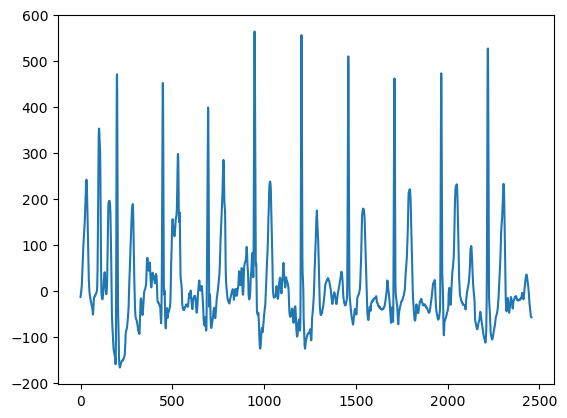

In [7]:
plt.plot(feature[0])
plt.plot(X_train_fourier[0]/100)
plt.show()
print('feature shape:',feature.shape)
print('fourier shape:',X_train_fourier.shape)
print('label shape:',label.shape)

In [13]:
# takes for ever
X_train_catch22 = Catch22().fit_transform(feature,label)

KeyboardInterrupt: 

In [8]:
X_all_features = pd.concat([X_train_fourier,X_heartpy_features,X_tsfel_features],axis=1)
X_all_features

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,11301.739846,6240.507665,11986.275387,2643.156518,24564.281596,19876.139944,12746.579700,17761.576025,15707.006404,29343.352938,...,299.804718,4223.587242,12783.209999,23293.870700,34811.243747,47250.480768,60509.881833,74208.404788,87778.497770,105.0
1,92522.260351,77149.415037,124118.801701,116093.883741,152316.270128,87372.139474,15568.920607,96371.274932,75185.989687,13136.878826,...,162.580094,2415.816905,8367.300786,16296.346594,24217.329817,31835.858132,39843.884688,49008.809034,59861.760865,75.0
2,20078.524499,71883.664327,122546.766195,163046.267932,149997.596162,169282.405091,159759.268187,158554.290586,178573.790629,95172.372177,...,1309.063414,19448.019628,56758.271546,91146.552166,113794.291520,127087.681910,134956.937398,139933.573831,143133.132074,49.0
3,30590.394153,38473.928735,32220.087777,40374.562501,67543.277750,54527.786688,64248.839512,63647.453418,46262.369713,54262.488079,...,1677.964784,29432.362652,102202.255590,184589.643590,245478.774478,281863.928205,302040.039507,314206.637423,323916.586838,84.0
4,17741.586562,61560.231189,58948.446174,64768.775549,20233.398761,69272.751320,63712.575771,88121.305486,40871.862582,14939.384750,...,729.931705,10720.861576,30892.681554,47777.218039,56642.641427,60679.492368,63691.659360,67834.198591,74164.696658,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,168833.932869,151095.426558,68368.636962,72996.304578,24605.323967,14299.269370,182085.736313,266710.138631,214273.348121,189373.758983,...,1995.421261,32854.993837,112355.891891,201993.371737,263172.939831,298458.094471,331258.761721,377053.823975,437522.850995,86.0
5113,3362.711400,2989.202763,3733.347565,14851.694557,12085.704770,10862.260348,16069.987442,10656.552190,41629.478941,44034.480984,...,250.604302,3663.004179,11482.451249,20872.554618,29842.998278,37343.287358,42763.282063,45966.880821,47269.343287,72.0
5114,27816.583074,74295.575856,143255.109176,128436.738173,57951.323577,22283.304987,34758.968308,56256.595666,76972.599828,82001.918843,...,1230.423388,19302.907699,61797.629918,108037.552884,143893.820978,169214.313008,188236.255129,203922.975273,217580.781414,66.0
5115,12683.367524,27052.739118,23359.507225,9713.706106,48317.173658,15369.508037,29983.052408,19258.741676,61294.121446,24725.158558,...,120.507560,1975.536980,6525.580774,11582.733160,15827.333082,19391.715479,22616.535852,25680.240346,28661.137852,74.0


In [13]:

class MyClassifier(torch.nn.Module):
    def __init__(self):
        super(MyClassifier, self).__init__()
        self.fc1 = nn.Linear(1637, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.do2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(512, 512)
        self.do3 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(512, 256)
        self.do4 = nn.Dropout(0.25)
        self.fc5 = nn.Linear(256, 128)
        self.do5 = nn.Dropout(0.25)
        self.fc6 = nn.Linear(128, 64)
        self.do6 = nn.Dropout(0.25)
        self.fc7 = nn.Linear(64, 4)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.do2(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.do3(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.do4(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.do5(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.do6(x)
        x = self.fc7(x)
        
        return x

In [12]:
class MyDataset(Dataset):
    def __init__(self,dataframe,label):
        self.data = dataframe
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data.iloc[idx,:].to_numpy(),F.one_hot(torch.tensor(self.label.iloc[idx]),num_classes=4)

In [27]:
def timeSerClassifier(_X_train, _y_train):
    classifier = TimeSeriesForestClassifier()
    classifier.fit(_X_train, _y_train)
    return classifier

In [8]:
def cnnClassifier(_X_train, _y_train):
    classifier = CNNClassifier(n_epochs=100)
    classifier.fit(_X_train, _y_train)
    return classifier

In [13]:
print(X_all_features.shape)
X_all_features = X_all_features.set_axis(range(X_all_features.shape[1]),axis=1).dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_all_features, label,stratify=label)
train_dataset = MyDataset(X_train,y_train)
test_dataset = MyDataset(X_test,y_test)

dl_train = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4)
dl_test = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=4)
X_train.head()

(5117, 1624)


,0,1,2,3,4,5,6,7,8,9,...,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623
2483,41441.692641,67666.546671,63855.724014,144148.127865,69528.374662,29688.235833,164556.776632,222489.287440,28690.955016,96273.081839,...,809.699804,13554.185753,51818.165373,105214.818206,158361.006780,205869.883689,249416.157915,293815.371372,344180.876639,57.0
3417,2482.597288,5142.453552,5541.752248,3794.128223,14232.519154,16134.777201,9540.265707,9301.834756,6046.278929,29110.451562,...,331.871216,5379.155058,17544.122144,30740.443851,40681.434167,46960.882210,50617.818405,52939.315349,55070.311667,98.0
41,9444.154557,8875.682624,30696.505447,27751.522916,23712.196011,27397.690910,13921.740994,27520.794672,22258.093587,27252.580710,...,704.324577,13375.294314,51356.161164,103335.709105,152542.057880,192000.173001,221572.714682,243283.468409,259056.751333,98.0
937,73365.238823,13438.829512,171425.283770,32901.212693,88205.030199,177666.777366,253511.200501,176325.822931,91032.171108,61324.499562,...,483.431218,7104.319039,23886.585176,47975.087365,78488.337376,116499.416326,162723.176291,216490.638269,275606.076754,50.0
492,88318.892572,74143.464925,117065.389986,242533.662709,281812.472647,198489.200040,166582.682392,172012.809950,187436.605194,161033.916702,...,720.836022,11965.823178,41608.647465,80095.064211,117619.234146,150894.802302,180669.450348,208197.572945,233811.398889,49.0


In [12]:
def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()         
        
        
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))
    
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

In [14]:
model = MyClassifier()
optimizer = optim.Adam(model.parameters())
for epoch in range(1, 10 + 1):
    train(model, dl_train, optimizer, epoch)
    test(model, dl_test)

In [9]:
model1 = XGBClassifier(n_estimators=300, max_depth=200, eta=0.2,random_state = 420, subsample = 0.8)

In [14]:
model1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=200,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [52]:
model2 = RandomForestClassifier(n_estimators=200, max_depth=700,random_state = 420, class_weight='balanced')

In [53]:
model2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=700, n_estimators=200,
                       random_state=420)

In [16]:

model3=HistGradientBoostingClassifier(learning_rate=0.05)

In [17]:
model3.fit(X_train,y_train)

HistGradientBoostingClassifier(learning_rate=0.05)

In [15]:
y_pred = model1.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')

score

0.64453125

In [69]:
# best n_estimators: 300 best max_depth: 200 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0
# best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0
n_estimators = [300, 400, 500]
max_depth = [100, 150, 200]
subsample = [0.7, 0.8, 0.9]
etas = [0.1,0.2, 0.3]
best_n_estimators = 0
best_max_depth = 0
best_subsample = 0
best_eta = -1
best_score = 0
best_score_train = 0
i=0
for n_e in n_estimators:
    for m_d in max_depth:
        for s_s in subsample:
            for eta in etas:
                model_test = XGBClassifier(n_estimators=n_e, max_depth=m_d, eta=eta,random_state = 420, subsample = s_s, verbosity=0, silent=True)
                model_test.fit(X_train, y_train)
                y_pred_test = model_test.predict(X_test)
                score_test = f1_score(y_test, y_pred_test, average='micro')
                y_pred_train = model_test.predict(X_train)
                score_train = f1_score(y_train, y_pred_train, average='micro')
                if score_test > best_score:
                    best_n_estimators = n_e
                    best_max_depth = m_d
                    best_subsample = s_s
                    best_eta = eta
                    best_score = score_test
                    best_score_train = score_train
                print((i/81)*100,'%')
                print('best n_estimators:',best_n_estimators,'best max_depth:',best_max_depth,'best subsample:',best_subsample,'best eta:',best_eta,'best score:',best_score,'best score train:',best_score_train)
                i+=1
    

c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramD

0.0 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.7 best eta: 0.1 best score: 0.63671875 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

1.2345679012345678 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.7 best eta: 0.2 best score: 0.6375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

2.4691358024691357 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.7 best eta: 0.2 best score: 0.6375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

3.7037037037037033 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.7 best eta: 0.2 best score: 0.6375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

4.938271604938271 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

6.172839506172839 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

7.4074074074074066 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

8.641975308641975 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

9.876543209876543 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

11.11111111111111 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

12.345679012345679 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

13.580246913580247 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

14.814814814814813 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

16.049382716049383 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

17.28395061728395 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

18.51851851851852 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

19.753086419753085 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

20.98765432098765 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

22.22222222222222 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

23.456790123456788 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

24.691358024691358 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

25.925925925925924 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

27.160493827160494 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

28.39506172839506 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

29.629629629629626 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

30.864197530864196 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

32.098765432098766 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

33.33333333333333 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.

34.5679012345679 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

35.80246913580247 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

37.03703703703704 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

38.2716049382716 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

39.50617283950617 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

40.74074074074074 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.

41.9753086419753 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

43.20987654320987 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

44.44444444444444 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

45.67901234567901 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

46.913580246913575 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

48.148148148148145 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

49.382716049382715 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

50.617283950617285 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

51.85185185185185 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

53.086419753086425 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

54.32098765432099 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

55.55555555555556 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

56.79012345679012 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

58.0246913580247 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

59.25925925925925 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

60.49382716049383 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

61.72839506172839 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

62.96296296296296 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

64.19753086419753 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

65.4320987654321 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

66.66666666666666 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

67.90123456790124 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

69.1358024691358 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

70.37037037037037 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

71.60493827160494 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

72.8395061728395 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

74.07407407407408 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

75.30864197530865 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

76.5432098765432 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

77.77777777777779 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

79.01234567901234 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

80.24691358024691 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

81.48148148148148 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

82.71604938271605 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

83.9506172839506 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

85.18518518518519 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

86.41975308641975 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

87.65432098765432 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

88.88888888888889 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

90.12345679012346 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

91.35802469135803 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

92.5925925925926 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

93.82716049382715 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

95.06172839506173 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: Fut

96.29629629629629 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

97.53086419753086 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\lib\s

98.76543209876543 %
best n_estimators: 300 best max_depth: 100 best subsample: 0.8 best eta: 0.2 best score: 0.64375 best score train: 1.0


c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [57]:
df = pd.DataFrame(X_train_fourier)
df.to_csv('fourier.csv', index=False)